# Creating Loneliness Index for GPs in Northern Ireland using Prescription Data, 2022

- Outputs an index of loneliness scores for GPs' postcodes in NI for Jan 2022 - Dec 2022 
- To be used as an input to map area scores

### Check you are in a venv

In [1]:
import sys
import os
if sys.base_prefix != sys.prefix:
    venv_name = os.path.basename(sys.prefix)
    print(f"You are in a virtual environment - {venv_name}")
else:
    print("You are not in a virtual environment. Activate your venev")

You are in a virtual environment - venv_loneliness


In [2]:
!pip install openpyxl

You should consider upgrading via the 'c:\users\jennatan\documents\loneliness\venv_loneliness\scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
import zipfile as zp

In [4]:
# Path to files
path = "../../extdata/"

# Read drug data

In [5]:
drug_data = pd.read_csv("../../extdata/drug_list.csv")

# Process Prescribing and GP postcode data
- Uses monthly "GP Data Extract" files that come from: https://nwssp.nhs.wales/ourservices/primary-care-services/general-information/data-and-publications/prescribing-data-extracts/general-practice-prescribing-data-extract/ to identify loneliness related conditions based on prescriptions
- Each zip file contains prescription info and GP contact details
- This block of code iterates through each zip folder, counts loneliness related prescriptions from the GPData file and joins it to the address files to get the GP's postcode
- Outputs a dataframe that multiplies loneliness related prescriptions by its count.

  
The data covers prescriptions that are prescribed in Wales by GP's (general medical practitioners) and non medical prescribers that have prescribed on behalf of the GP practice, that are then dispensed in the community within Wales or England. The data includes all prescribed medicines, dressings and appliances that are dispensed each month. If a patient does not take a prescription to the pharmacy for dispensing, then the information will not be included in the dataset. Private prescriptions are not included in the data.

**Prescription in the Community files for each month in 2022 need to be manually downloaded from the link above and saved in the pitc_wales/ folder**

In [6]:
# Create prescriptions folder if doesn't already exist
folder_path = Path("../../extdata/pitc_wales")
if not folder_path.exists():
    folder_path.mkdir(parents=True)

In [7]:
# column names
col_bnfname = "BNFName"
col_items = "Items"

In [8]:
# Function to find loneliness related conditions based on prescription
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
  
    # Return dataframe multiplied by counts of items
    return out.multiply(x[col_items], axis=0)

In [9]:
# Define the aggregation methods per column
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
for key in ['pcstrip', 'Postcode']:
    agg_cols[key] = 'first'

In [10]:
monthly_data = []

for file in os.listdir(path + "pitc_wales"):
    with zp.ZipFile(path + "pitc_wales/" + file) as zipf:
        zip_names = zipf.namelist()
        
        # Preprocess prescribing files
        prescribe_name = next((filename for filename in zip_names if "GPData" in filename), None)
        prescribe = pd.read_csv(zipf.open(prescribe_name))
        prescribe.columns = prescribe.columns.str.strip()
        prescribe = prescribe[['PracticeID', col_bnfname, col_items]]
        ## Count prescriptions
        loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
        ## Merge dfs across the months
        prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
        del loneliness_prescribing
        
        # Preprocess address files
        addr_name = next((filename for filename in zip_names if "Address" in filename), None)
        addr = pd.read_csv(zipf.open(addr_name))
        addr = addr[['PracticeId', 'Postcode']]

        # Merge prescribing files and address files
        prescribe = prescribe.merge(addr, left_on = 'PracticeID', right_on = 'PracticeId')
        del addr

        # Create uniform postcode field
        prescribe['pcstrip'] = prescribe['Postcode'].str.replace(" ","")

        # Group by GP per month 
        summary = prescribe.groupby('PracticeID', as_index=False).agg(agg_cols) # Use agg method dict from cell above
        del prescribe
        
        # Append each month to a list
        monthly_data.append(summary)
        print(f" Completed processing {file}")


 Completed processing GPData202201.zip
 Completed processing GPData202202.zip
 Completed processing GPData202203.zip
 Completed processing GPData202204.zip
 Completed processing GPData202205.zip
 Completed processing GPData202206.zip
 Completed processing GPData202207.zip
 Completed processing GPData202208.zip
 Completed processing GPData202209.zip
 Completed processing GPData202210.zip
 Completed processing GPData202211.zip
 Completed processing GPData202212.zip


In [11]:
# concatenate all the monthly data together
monthly_prescriptions = pd.concat(monthly_data, ignore_index = True)
# monthly_prescriptions.drop(columns = ["PracticeId", "Postcode", , inplace = True)
print(monthly_prescriptions.shape)
monthly_prescriptions.head()

(5779, 12)


,PracticeID,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,Items,pcstrip,Postcode
0,W00005,2081,62,2066,376,1406,111,2,0,19321,CF834AU,CF83 4AU
1,W00007,1412,19,1255,169,907,81,1,12,14695,LL113NS,LL11 3NS
2,W00016,0,0,0,0,0,0,0,0,1,NP183XQ,NP18 3XQ
3,W00019,7,0,2,0,1,2,0,0,779,CH51XS,CH5 1XS
4,W00021,14,0,8,1,2,6,0,0,1134,NP447XX,NP44 7XX


In [12]:
# Groupby practice ID again to get figures across the year
monthly_prescriptions = monthly_prescriptions.groupby('PracticeID', as_index= False).agg(agg_cols)

In [13]:
print(monthly_prescriptions.PracticeID.nunique())
monthly_prescriptions.shape

536


(536, 12)

In [14]:
# Check no duplicates
monthly_prescriptions.duplicated().value_counts()

False    536
Name: count, dtype: int64

No duplicates

In [15]:
# Save aggregated data
monthly_prescriptions.to_csv(path + "monthly_prescriptions.csv")

### Subset dataset for GPs only

Dataset includes non GPs, e.g. pharmacies. Isolate for GPs only using list of GP practices here https://nwssp.nhs.wales/ourservices/primary-care-services/general-information/data-and-publications/prescribing-data-extracts/gp-practice-analysis/

**GP Practice Analysis 2022 needs to be manually downloaded into the inst/extdata/gp_details_wales/ folder**

In [16]:
# Create gp details folder if doesn't already exist
folder_path = Path("../../extdata/gp_details_wales")
if not folder_path.exists():
    folder_path.mkdir(parents=True)

In [17]:
gp = pd.read_excel(path+ "gp_details_wales/PracticeItemsDecember2022.xlsx")

In [18]:
gp_ids = gp.PracticeID.unique()
prescriptions_gp = monthly_prescriptions[monthly_prescriptions['PracticeID'].isin(gp_ids)].copy()

In [19]:
# Check data subsetting properly
len(prescriptions_gp) == gp.PracticeID.nunique()
print(prescriptions_gp.shape)

(475, 12)


In [20]:
# Check number of GP Practices with multiple postcodes - none
prescriptions_gp.groupby('PracticeID')['pcstrip'].count().sort_values(ascending=False).head(10)

PracticeID
W00005    1
W95034    1
W95051    1
W95050    1
W95049    1
W95046    1
W95044    1
W95043    1
W95042    1
W95041    1
Name: pcstrip, dtype: int64

# Generate Statistics from Prescribing Counts
- Compute percentages per condition as total of all drugs prescribed per postcode
- Compute z-score per condition across postcodes
- Add z-scores of all conditions together to compute a loneliness score per postcode
- The loneliness variable is an equally weighted index of the conditions.

In [21]:
prescriptions_gp.reset_index(inplace = True)
prescriptions_gp.head(2)

,index,PracticeID,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,Items,pcstrip,Postcode
0,1,W00005,26547,805,25481,4786,17511,1503,15,2,247909,CF834AU,CF83 4AU
1,3,W00007,18294,218,15920,2042,11168,1132,22,168,188803,LL113NS,LL11 3NS


In [22]:
prescriptions_gp = prescriptions_gp.drop(columns = ['Postcode','PracticeID'])
prescriptions_gp.head(2)

,index,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,Items,pcstrip
0,1,26547,805,25481,4786,17511,1503,15,2,247909,CF834AU
1,3,18294,218,15920,2042,11168,1132,22,168,188803,LL113NS


In [23]:
# Generate percentages for discrete illness groups out of total drugs prescribed

illness_cols = drug_data['illness'].unique()
target_cols = illness_cols + '_perc'

prescriptions_gp[target_cols] = prescriptions_gp[illness_cols].divide(prescriptions_gp[col_items], axis=0) * 100


In [24]:
prescriptions_gp.head(2)

,index,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,Items,pcstrip,depression_perc,alzheimers_perc,hypertension_perc,diabetes_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc
0,1,26547,805,25481,4786,17511,1503,15,2,247909,CF834AU,10.708365,0.324716,10.278368,1.930547,7.063479,0.606271,0.006051,0.000807
1,3,18294,218,15920,2042,11168,1132,22,168,188803,LL113NS,9.689465,0.115464,8.432069,1.081551,5.915160,0.599567,0.011652,0.088982


## Standardisation

In [25]:
# Calculate the z scores per illness across postcodes

for i, col in enumerate(target_cols):
    col_zscore = col[:-5] + '_zscore'  # Create new columns for z-scores
    prescriptions_gp[col_zscore] = stats.zscore(prescriptions_gp[col])


In [26]:
col_zscore

'social anxiety_zscore'

In [27]:
# Add conditions z scores for overall loneliness z score
prescriptions_gp['loneliness_zscore'] = prescriptions_gp[[ 'depression_zscore', 'alzheimers_zscore', 'hypertension_zscore', 'diabetes_zscore',
       'cardiovascular disease_zscore', 'insomnia_zscore', 'addiction_zscore',
       'social anxiety_zscore']].sum(axis=1)

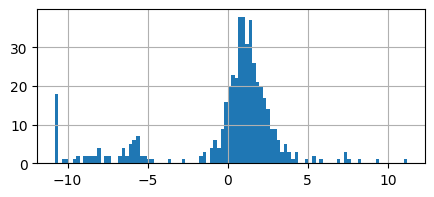

In [28]:
prescriptions_gp.loneliness_zscore.hist(bins=100, figsize = (5,2));

In [29]:
prescriptions_gp.rename(columns={'pcstrip':'postcode'}, inplace = True)

In [30]:
loneliness_postcode = prescriptions_gp[['postcode','loneliness_zscore']]

In [31]:
loneliness_postcode

,postcode,loneliness_zscore
0,CF834AU,2.399497
1,LL113NS,0.925179
2,CH51XS,-9.410786
3,NP447XX,-9.505654
4,NP447XX,-5.601233
...,...,...
470,SA18QY,0.133378
471,SA14DF,1.347957
472,SA55LB,1.534971
473,SA129PY,1.799301


In [32]:
# Save aggregated data
# loneliness_postcode.to_csv(path + "wales_gp_2022.csv", index = False)